In [11]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [ ]:
# government aid to jeju island  

In [ ]:
# 1. data preprocessing

In [15]:
#data load
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rc('font', family='AppleGothic')

import folium 
import geopandas as gpd
from IPython.display import Image

import tqdm # progress bar 
import os, sys

from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [13]:
pip install google.colab

  Using cached google_colab-1.0.0-py2.py3-none-any.whl
  Using cached notebook-5.2.2-py2.py3-none-any.whl (8.0 MB)
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Using cached google_auth-1.4.2-py2.py3-none-any.whl (64 kB)


  ERROR: Command errored out with exit status 1:
   command: /Users/yeonghwanchoi/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/setup.py'"'"'; __file__='"'"'/private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-wheel-yhr7hr1y
       cwd: /private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/
  Complete output (921 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.m

Failed to build pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.3
    Uninstalling pandas-1.2.3:
      Successfully uninstalled pandas-1.2.3
    Running setup.py install for pandas ... error
    ERROR: Command errored out with exit status 1:
     command: /Users/yeonghwanchoi/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/setup.py'"'"'; __file__='"'"'/private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-record-a984ws0y/install-record.txt --single-version-externally-managed --compile --ins

ERROR: Command errored out with exit status 1: /Users/yeonghwanchoi/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/setup.py'"'"'; __file__='"'"'/private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-install-p46gsk6u/pandas_ae47ca3789214657a950bd2bda6ef283/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/d5/s78kb8hn4n53qrl1n38dtj2c0000gn/T/pip-record-a984ws0y/install-record.txt --single-version-externally-managed --compile --install-headers /Users/yeonghwanchoi/opt/anaconda3/include/python3.8/pandas Check the logs for full command output.
Note: you may need to restart the kernel to use updated packages.


In [12]:
#path /content/drive

In [7]:
path='https://drive.google.com/drive/u/0/folders/1k9rpr3kO0fqpFfsvpkRbmEJifa2SXQgJ'
data5=pd.read_csv( path+'/KRI-DAC_Jeju_data5.txt')

HTTPError: HTTP Error 400: Bad Request

In [1]:
# from IPython.display import GeoJSON

# GeoJSON({
#     "type": "Feature",
#     "geometry": {
#         "type": "Point",
#         "coordinates": [-118.4563712, 34.0163116]
#     }
# })

In [2]:
import sys
from data import api_key 
key=api_key.google_api_key

In [3]:
# load data
from glob import glob 
raw_data = glob("data/*.txt")
raw_data[0]

'data/KRI-DAC_Jeju_data6.txt'

In [4]:
# conncat data
from glob import glob 
concat_list=[]
for i in range(0,len(raw_data)):
    df=pd.read_csv(raw_data[i])
    df["month"]=raw_data[i].split(".")[0][-1:]
    concat_list.append(df)

In [5]:
df=pd.concat(concat_list)

In [6]:
#dropped useless columns 
df.columns=df.columns.str.lower()
df.drop(['sido','x',"objectid",'y'],axis = 1, inplace=True)

In [7]:
#rename koren named columns to eng
df

,field1,ym,sigungu,franclass,type,time,totalspent,disspent,numofspent,numofdisspent,point_x,point_y,month
0,1,202006,제주시,영세,일반한식,00시,502000,0,10,0,877005.9834,1.479766e+06,6
1,2,202006,제주시,영세,단란주점,00시,1520000,0,8,0,877005.7447,1.479816e+06,6
2,3,202006,제주시,중소1,편의점,00시,482310,0,35,0,877056.6756,1.479616e+06,6
3,4,202006,제주시,영세,편의점,00시,38050,5450,3,1,877055.9593,1.479766e+06,6
4,5,202006,제주시,영세,일반한식,00시,32000,32000,1,1,877055.4817,1.479866e+06,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280080,280081,202008,제주시,영세,편의점,x시,13700,0,2,0,950266.5976,1.502458e+06,8
280081,280082,202008,제주시,영세,일반한식,x시,56000,0,1,0,950317.5379,1.502258e+06,8
280082,280083,202008,제주시,영세,일반한식,x시,28000,0,1,0,950469.1585,1.501909e+06,8
280083,280084,202008,제주시,중소1,중국음식,x시,46000,0,3,0,950574.6388,1.500760e+06,8


In [8]:
from pyproj import Proj, transform 
proj_itrf = Proj(init='epsg:5178')
proj_wgs84 = Proj(init='epsg:4326')
df["lon"],df["lat"] = transform(proj_itrf,proj_wgs84,df['point_x'],df["point_y"])
df.drop(['point_x','point_y',"field1",'ym'],inplace=True, axis=1)

In [9]:
# df['lon_lat']=df['lon'].astype(str)+'_'+df['lat'].astype(str)

In [10]:
# df_lon_lat=df['lon_lat'].drop_duplicates()
# df_lon_lat

In [11]:
# import googlemaps
# from datetime import datetime

# gmaps = googlemaps.Client(key) 
# reverse_geocode_result = gmaps.reverse_geocode((33.302315,126.176746))
# reverse_geocode_result
# # geocode_result  

In [12]:
# import json
# m=folium.Map(location=[48,-102],zoom_start=3)
# folium.Choropleth(
#     geo_data='./data/03_us-states.json',
#     data=state_data, columns=["State",'Unemployment'],
#     nan_fill_color="purple", nan_fill_opacity=0.4,
#     key_on="    ", fill_color="YlGn",
#     legend_name="Unemployment Rate (%)"
# ).add_to(m)
# m

In [13]:
#import rename module  
import type_names
input_data=type_names.rename()
for key, value in input_data:
    df["type"].replace(dict.fromkeys(key, value), inplace=True)

In [14]:
df

,sigungu,franclass,type,time,totalspent,disspent,numofspent,numofdisspent,month,lon,lat
0,제주시,영세,dinning,00시,502000,0,10,0,6,126.176746,33.305090
1,제주시,영세,liquor,00시,1520000,0,8,0,6,126.176737,33.305540
2,제주시,중소1,grocery,00시,482310,0,35,0,6,126.177311,33.303746
3,제주시,영세,grocery,00시,38050,5450,3,1,6,126.177283,33.305098
4,제주시,영세,dinning,00시,32000,32000,1,1,6,126.177264,33.305999
...,...,...,...,...,...,...,...,...,...,...,...
280080,제주시,영세,grocery,x시,13700,0,2,0,8,126.962369,33.515632
280081,제주시,영세,dinning,x시,56000,0,1,0,8,126.962928,33.513833
280082,제주시,영세,dinning,x시,28000,0,1,0,8,126.964580,33.510691
280083,제주시,중소1,dinning,x시,46000,0,3,0,8,126.965779,33.500332


In [15]:
# data preprocessing

df['sigungu']=df['sigungu'].replace(['제주시','서귀포시'],['jeju','Seogwipo'])
df=df[df['time']!='x시'].reset_index(drop=True) # payments canceled 
df['time']=df['time'].apply(lambda x : x[:2])
df.franclass=df.franclass.replace(['영세', '중소1', '중소', '중소2', '일반'],['under_0.3m','under_1m','under_0.5m','under_3m','over_3m'])
df_final=df.rename(columns={'sigungu':'city','franclass':'class','totalspent':'total_income','disspent':'subsidies_income','numofspent':'num_of_payments','numofdisspent':'num_of_subspayment'})
df_final[['total_income','subsidies_income']]=df_final[['total_income','subsidies_income']].astype(int).apply(lambda x:x/1000) #won to $, 1000:1
df_final['non_subsidies_income']=df_final['total_income']-df_final['subsidies_income']

In [16]:
df_final['month'].unique()

array(['6', '7', '5', '8'], dtype=object)

<Figure size 720x432 with 0 Axes>

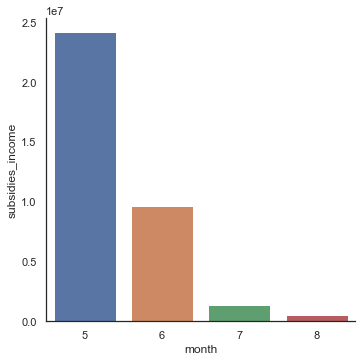

In [17]:
# visualization 
#1. subsidies_income by month 
df_month_group=df_final.groupby('month')["subsidies_income"].sum().reset_index()

plt.figure(figsize=(10,6))
sns.catplot(x="month", y="subsidies_income", ci=None, kind="bar", data=df_month_group);

In [18]:
df_final

,city,class,type,time,total_income,subsidies_income,num_of_payments,num_of_subspayment,month,lon,lat,non_subsidies_income
0,jeju,under_0.3m,dinning,00,502.00,0.00,10,0,6,126.176746,33.305090,502.00
1,jeju,under_0.3m,liquor,00,1520.00,0.00,8,0,6,126.176737,33.305540,1520.00
2,jeju,under_1m,grocery,00,482.31,0.00,35,0,6,126.177311,33.303746,482.31
3,jeju,under_0.3m,grocery,00,38.05,5.45,3,1,6,126.177283,33.305098,32.60
4,jeju,under_0.3m,dinning,00,32.00,32.00,1,1,6,126.177264,33.305999,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1072434,jeju,under_0.3m,dinning,23,65.00,0.00,4,0,8,126.954829,33.516019,65.00
1072435,jeju,under_0.3m,grocery,23,738.45,0.00,36,0,8,126.954829,33.516019,738.45
1072436,jeju,under_0.5m,grocery,23,331.63,0.00,26,0,8,126.954818,33.516921,331.63
1072437,jeju,under_0.3m,grocery,23,374.10,0.00,12,0,8,126.955373,33.515573,374.10


Text(0.5, 1.0, 'subsidies_income by city')

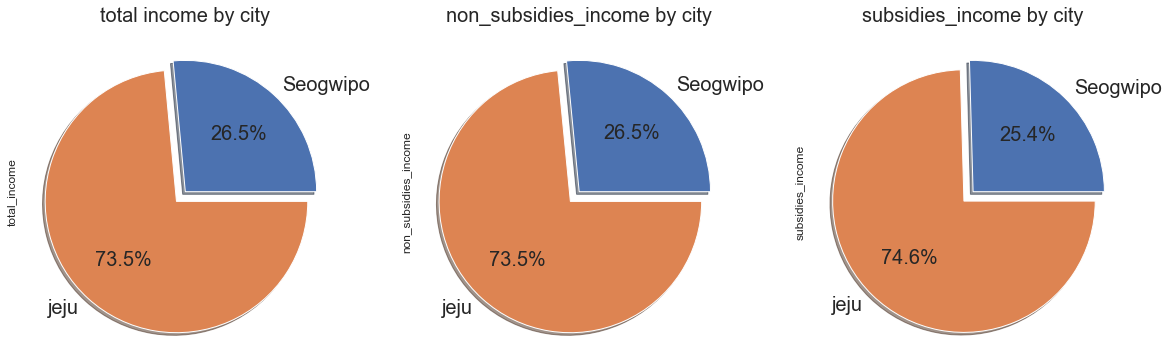

In [19]:
# all income by city 
# population = jeju_city (507,095), seogwipo (190,254), seogwipo/jeju_city = 0.375
df_city_group= df_final.groupby('city')['total_income','non_subsidies_income',"subsidies_income"].sum() 
df_city_group

f, ax = plt.subplots(1,3, figsize=(20,10))

df_city_group['total_income'].plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0], shadow=True,fontsize=20)
ax[0].set_title('total income by city',fontsize=20)

df_city_group['non_subsidies_income'].plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[1], shadow=True,fontsize=20)
ax[1].set_title('non_subsidies_income by city',fontsize=20)

df_city_group['subsidies_income'].plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[2], shadow=True, fontsize=20)
ax[2].set_title('subsidies_income by city',fontsize=20)


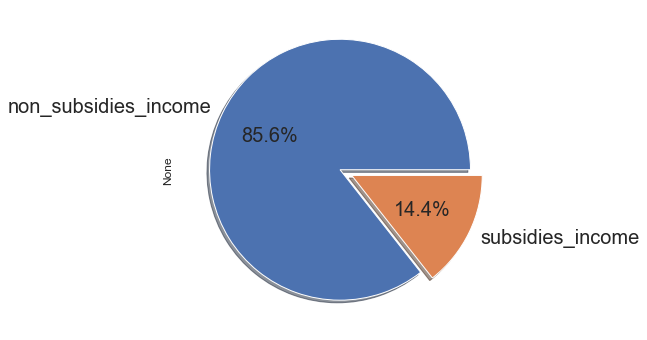

In [20]:
#
df_5=df_final[df_final['month']=='5']
df_5_sum=df_5[['non_subsidies_income','subsidies_income']].sum()

plt.figure(figsize=(10,6))
df_5_sum_plot=df_5_sum.plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True,fontsize=20)


In [21]:
df_5_group_type=df_5.groupby('type')['total_income','non_subsidies_income',"subsidies_income"].sum() 
df_5_group_type.iloc[1]

total_income            1.292806e+07
non_subsidies_income    1.091423e+07
subsidies_income        2.013829e+06
Name: automobile, dtype: float64

In [22]:
#error fix
df_5_group_type.loc['beauty']=df_5_group_type.loc['beauty']+df_5_group_type.loc['화장품']
df_5_group_type.drop(index='화장품', inplace=True)

In [23]:
df_5_group_type['replacement_rate']=df_5_group_type['subsidies_income']/df_5_group_type['non_subsidies_income']
df_5_group_type.sort_values('replacement_rate',ascending=False)

,total_income,non_subsidies_income,subsidies_income,replacement_rate
type,,,,
agriculture,6.499023e+06,4.669299e+06,1829724.194,0.391863
grocery,4.010482e+07,3.236285e+07,7741962.050,0.239224
housing,1.386279e+06,1.147461e+06,238817.841,0.208127
beauty,1.099585e+06,9.206987e+05,178886.697,0.194295
construction,4.322700e+06,3.621635e+06,701065.099,0.193577
automobile,1.292806e+07,1.091423e+07,2013829.169,0.184514
medical,1.110183e+07,9.426260e+06,1675572.420,0.177756
dinning,3.804076e+07,3.264970e+07,5391056.740,0.165118
service,4.397064e+06,3.777110e+06,619954.400,0.164135
